# 0.0 Imports 

In [65]:
import random
import pickle
import numpy   as np
import pandas  as pd
import seaborn as sns
import xgboost as xgb


from IPython.display      import Image
from pandas_profiling     import ProfileReport
from IPython.core.display import HTML

from boruta                        import BorutaPy
from sklearn                       import tree
from sklearn                       import svm
from lightgbm                      import LGBMClassifier
from sklearn.dummy                 import DummyClassifier
from sklearn.metrics               import classification_report
from sklearn.metrics               import precision_score, accuracy_score, f1_score, recall_score
from sklearn.ensemble              import RandomForestClassifier
from sklearn.neighbors             import NearestCentroid
from sklearn.naive_bayes           import GaussianNB
from sklearn.linear_model          import LogisticRegression,SGDClassifier
from sklearn.model_selection       import StratifiedKFold, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


## 0.1 Helper functions

In [2]:
def calculate_model_metrics( y_test, y_pred ):
    
    #calculate precision
    precision = precision_score( y_test, y_pred)

    #calculate accuracy
    accuracy = accuracy_score( y_test, y_pred)

    #calculate f1_score
    f1 = f1_score( y_test, y_pred)

    #calculate recall
    recall = recall_score( y_test, y_pred)
    
    return precision, accuracy, f1, recall
    def get_classifiers_performance(X_train, X_test, y_train, y_test, classifiers):

        # creates empty data frame
        df_performance = pd.DataFrame()

        for clf in classifiers:
            print("Training " + type(clf).__name__ + "...")
            # fits the classifier to training data
            clf.fit(X_train, y_train)

            # predict the probabilities
            y_pred = clf.predict(X_test)

            # calculates model metrics
            clf_precision, clf_accuracy, clf_f1, clf_recall = calculate_model_metrics( y_test, y_pred)

            # creates a dict
            clf_dict = {
                'model': [type(clf).__name__, '---'],
                'precision': [clf_precision, np.nan],
                'recall': [clf_recall, np.nan],
                'f1-Score': [clf_f1, np.nan],
                'accuracy': [clf_accuracy, np.nan]}

            # concatenate Data Frames
            df_performance = pd.concat([df_performance, pd.DataFrame(clf_dict)])

        # resets Data Frame index
        df_performance = df_performance.reset_index()

        # drops index
        df_performance.drop('index', axis=1, inplace=True)

        # gets only the odd numbered rows
        rows_to_drop = np.arange(1, len(classifiers)*2, 2)

        # drops unwanted rows that have no data
        df_performance.drop(rows_to_drop, inplace=True)

        # returns performance summary
        return df_performance


In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [4]:
jupyter_settings()
pd.set_option('display.float_format', lambda x: '%.5f' % x)

Populating the interactive namespace from numpy and matplotlib


/home/pc/anaconda/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## 0.2 Data Loading

In [5]:
#open csv file

df_raw = pd.read_csv('../data/cardio_train.csv')


# 1.0 Data Description

In [6]:
df1 = df_raw.copy()

## 1.1 Rename Columns 

In [7]:
df1.columns


Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')


Don't need to rename any columns

## 1.2 Data Dimensions

In [8]:
print("Number of rows {}".format(df1.shape[0]))
print("Number of cols {}".format(df1.shape[1]))

Number of rows 70000
Number of cols 13


## 1.3 Data Types 

In [9]:
df1.dtypes

id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

## 1.4 Check NA 


In [10]:
df1.isna().sum()


id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64


As observed, don't has NA in the dataset
    

## 1.5 Descriptive Statistical

In [11]:
#Central tendency - mean, median
ct1 = pd.DataFrame(df1.apply(np.mean)).T
ct2 = pd.DataFrame(df1.apply(np.median)).T

#dispersion - std, min, max,  range, skew, kurtosis
d1 = pd.DataFrame(df1.apply(np.std)).T
d2 = pd.DataFrame(df1.apply(min)).T
d3 = pd.DataFrame(df1.apply(max)).T
d4 = pd.DataFrame(df1.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(df1.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(df1.apply(lambda x: x.kurtosis())).T

#concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()

m.columns = ['Atrib.','min','max','range','mean','median','std','skew','kurtosis']

In [12]:
m

Atrib.         min         max       range        mean      median         std     skew   kurtosis
0            id     0.00000 99999.00000 99999.00000 49972.41990 50001.50000 28851.09624 -0.00128   -1.19837
1           age 10798.00000 23713.00000 12915.00000 19468.86581 19703.00000  2467.23404 -0.30706   -0.82345
2        gender     1.00000     2.00000     1.00000     1.34957     1.00000     0.47683  0.63096   -1.60194
3        height    55.00000   250.00000   195.00000   164.35923   165.00000     8.21007 -0.64219    7.94365
4        weight    10.00000   200.00000   190.00000    74.20569    72.00000    14.39565  1.01207    2.58683
5         ap_hi  -150.00000 16020.00000 16170.00000   128.81729   120.00000   154.01032 85.29621 7580.07474
6         ap_lo   -70.00000 11000.00000 11070.00000    96.63041    80.00000   188.47118 32.11408 1425.91458
7   cholesterol     1.00000     3.00000     2.00000     1.36687     1.00000     0.68025  1.58712    0.99390
8          gluc     1.00000     3.00000     2.00000     1.22646     1.00000     0.57227  2.39746    4.29438
9         smoke     0.00000     1.00000     1.00000     0.08813     0.00000     0.28348  2.90587    6.44425
10         alco     0.00000     1.00000     1.00000     0.05377     0.00000     0.22557  3.95661   13.65513
11       active     0.00000     1.00000     1.00000     0.80373     1.00000     0.39718 -1.52947    0.33930
12       cardio     0.00000     1.00000     1.00000     0.49970     0.00000     0.50000  0.00120   -2.00006

# 2.0 Feature Engineering

In [13]:
df2 =df1.copy()

## 2.1 Mind Map

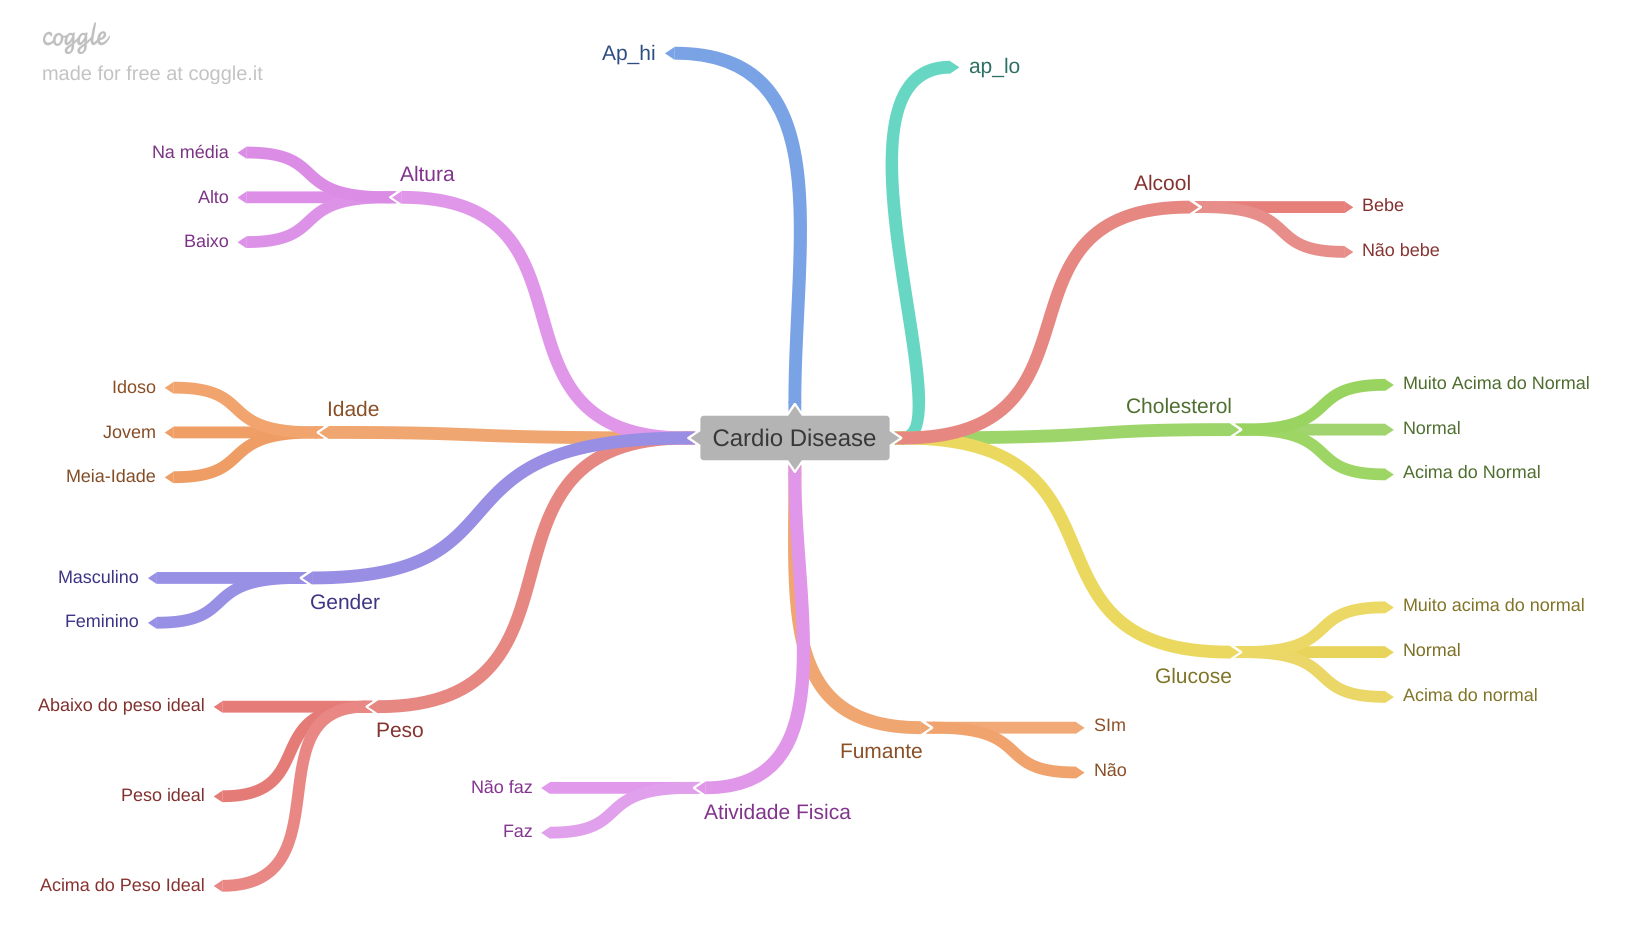

In [14]:
Image('img/mind_map_cardio.png')

## 2.1 Criação de Hipóteses

1. pessoas acima do peso deveriam ser mais propensas a ter cardio disease

2. pessoas acima do peso e fumantes deveriam ser mais propensas a ter cardio disease

3. pessoas acima do peso,fumantes e que não fazem atividade fisica deveriam ser mais propensas a ter cardio disease

4. pessoas fumantes e com colesterol muito acima do normal deveriam ser mais propensas a ter cardio disease

5. Homens com colesterol acima do normal e que não praticam atividade fisica deveriam ter mais chance de ter cardio disease

6. pessoas que com glicose mto acima do normal e colesterol mto acima do normal e que não praticam atividade fisica deveriam ser mais propensas a ter cardio disease

7. pessoas mais velhas e acima do peso deveriam ser mais propensas a ter cardio disease

8. pessoas mais velhas e com o colesterol mto acima do normal deveriam ser mais propensas a ter cardio disease

9. Homens deveriam ter mais chance de adquirir cardio disease do que as mulheres

10. homens que fumam e bembe deveriam ter mais chances do que mulheres que fumam e bebem.

## 2.2 Feature Engineering

In [15]:
#blood_pressure
# 1 - ap_hi < 120 e ap_lo < 80 
# 2 -  120<= ap_hi <= 129 e ap_lo < 80
# 3 -  130<= ap_hi <= 139 e 80 <= ap_lo <= 89
# 4 -  139 < ap_hi  e 89 < ap_lo 

df2['blood_pressure'] = df2.apply( (lambda x: 1 if (x['ap_hi'] < 120) & (x['ap_lo'] <= 80) else 2 if (120 <= x['ap_hi'] <= 129) & (x['ap_lo'] < 80) else 3 if (130 <= x['ap_hi'] < 139) or ( 80 <= x['ap_lo'] <= 89) else 4 ),axis =1 ) 

 
    



In [16]:
#IMC = WEIGHT/HEIGHT^2
df2['height2'] = df2['height']/100

df2['imc'] = (df2['weight']/(df2['height2']**2))

In [17]:
#imc_type
df2['imc_type'] = df2.apply( (lambda x : 1 if x['imc'] < 18.5 else 2 if  18.5 <= x['imc'] < 25.0 else 3 if 25 <= x['imc'] < 30.0 else 4 if  30.0 <= x['imc'] < 35.0 else 5 if 35 <= x['imc'] < 40.0 else 6) ,axis=1)

In [18]:
#create columns age by year
df2['age_years'] = df2['age'].apply(lambda x: x/365)

#round
df2['age_years'] = round(df2['age_years'], ndigits=0).astype(int)



## 2.3 Exclusão de colunas auxiliares

In [19]:
cols_drop = ['height2','imc']
df2 = df2.drop(cols_drop,axis=1)

# 3.0 EDA

In [20]:
df3 = df2.copy()

## 3.1 Analise Univariada

### 3.1.2 Variaveis Numericas 

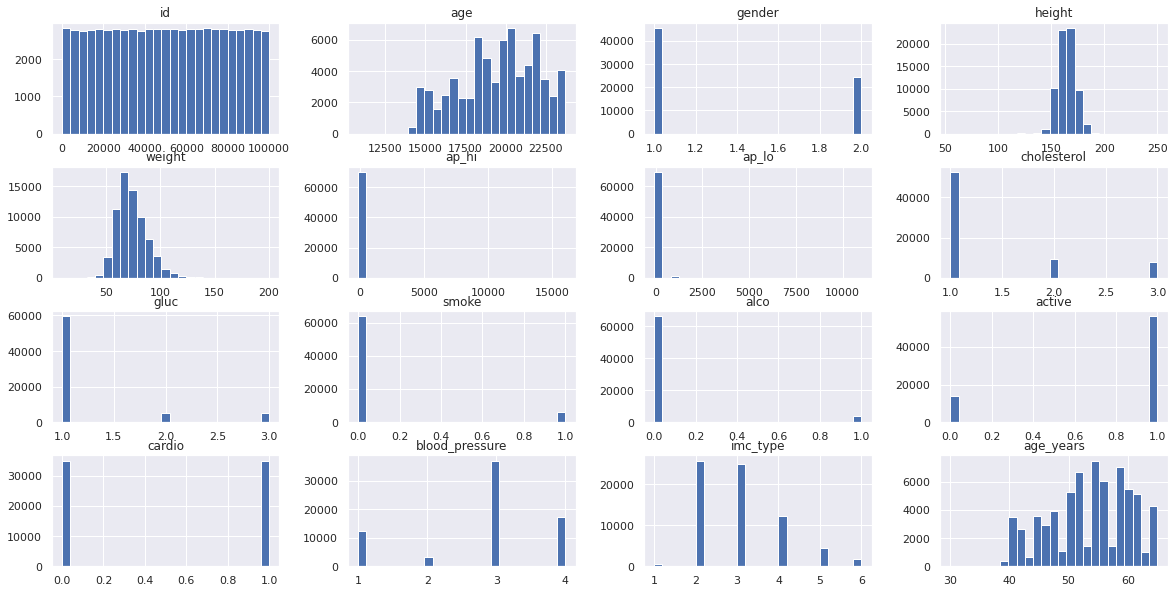

In [21]:
df3.hist(bins=25);

In [22]:
#more detailed plot of variables

#ProfileReport(df3, title="Pandas Profiling Report")


## 3.2 Analise Bivariada 

### H1- Pessoas acima  do peso ideal(levando em consideração o IMC) deveriam ser mais propensas a ter cardio disease
**TRUE** pessoas acima do seu ideal são mais propensas a ter cardio disease

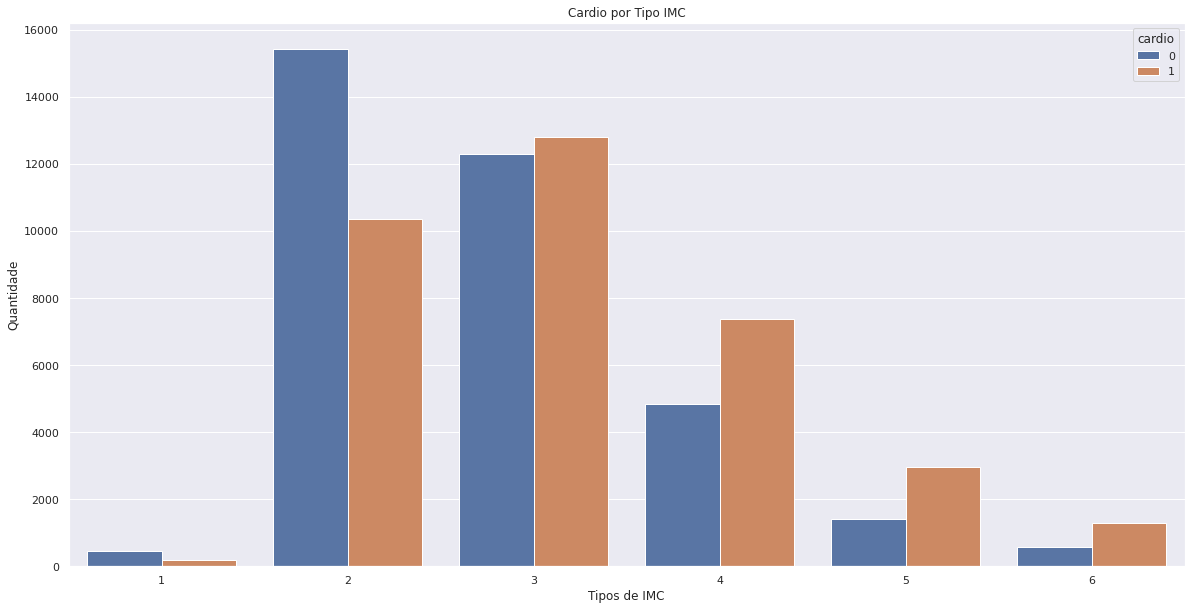

In [23]:

#plots graph
sns.countplot(x='imc_type', hue='cardio', data=df3);

#label
plt.title("Cardio por Tipo IMC");
plt.xlabel("Tipos de IMC");
plt.ylabel("Quantidade");

#plt.show()







### H2- Pessoas mais velhas  deveriam ser mais propensas a ter cardio disease
**TRUE** Pessoas mais velhas tem um indice maior de cardio disease

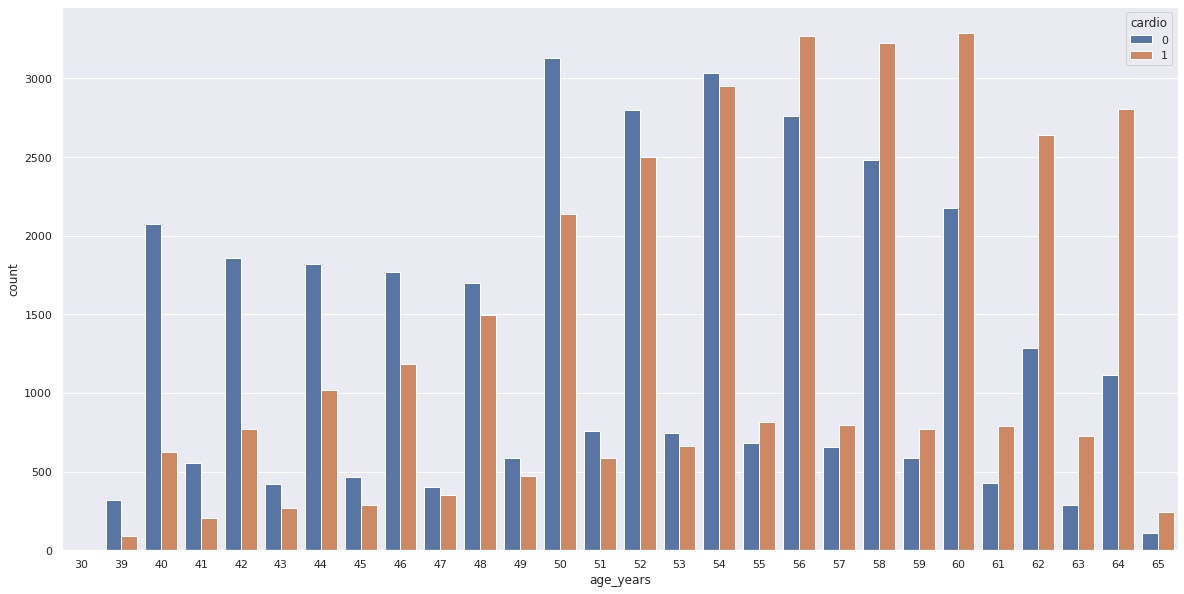

In [24]:

#plot graph
sns.countplot(x='age_years',hue='cardio',data=df3);



### H3- Pessoas que fumam deveriam ser mais propensas a ter cardio disease
**FALSE** pessoas que NÃO FUMAM tem um indice MAIOR de ter cardio diseas

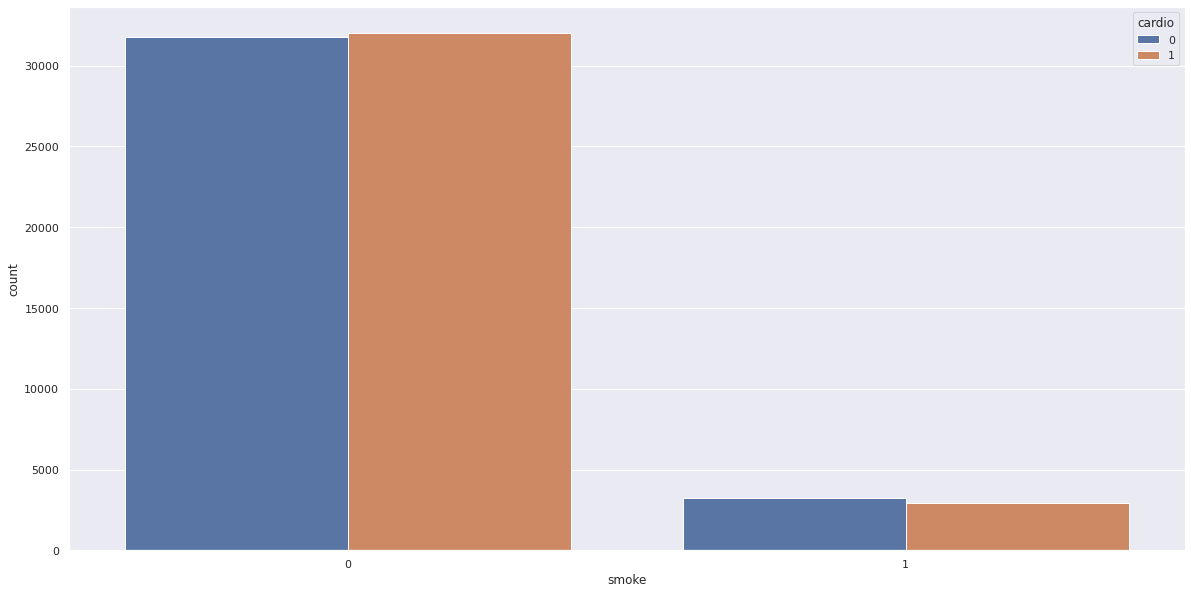

In [25]:


#plots graph
sns.countplot(x='smoke',hue='cardio', data=df3);




### H4- Pessoas que bebem alcool deveriam ser mais propensas a ter cardio disease
**False** Pessoas que BEBEM NÃO TEM mais propensão para cardio disease

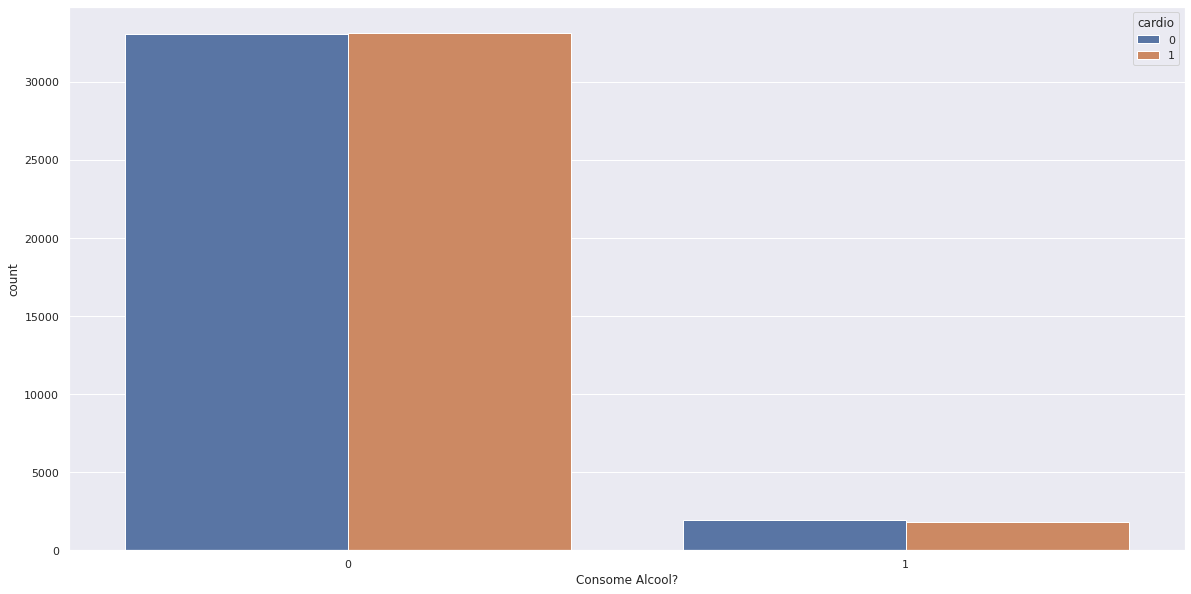

In [26]:
#plot graph
sns.countplot(x='alco',hue='cardio',data =df3);


plt.xlabel("Consome Alcool?");

### H5- Pessoas que não praticam atividade fisica deveriam ser mais propensas a ter cardio disease
**Verdade** 

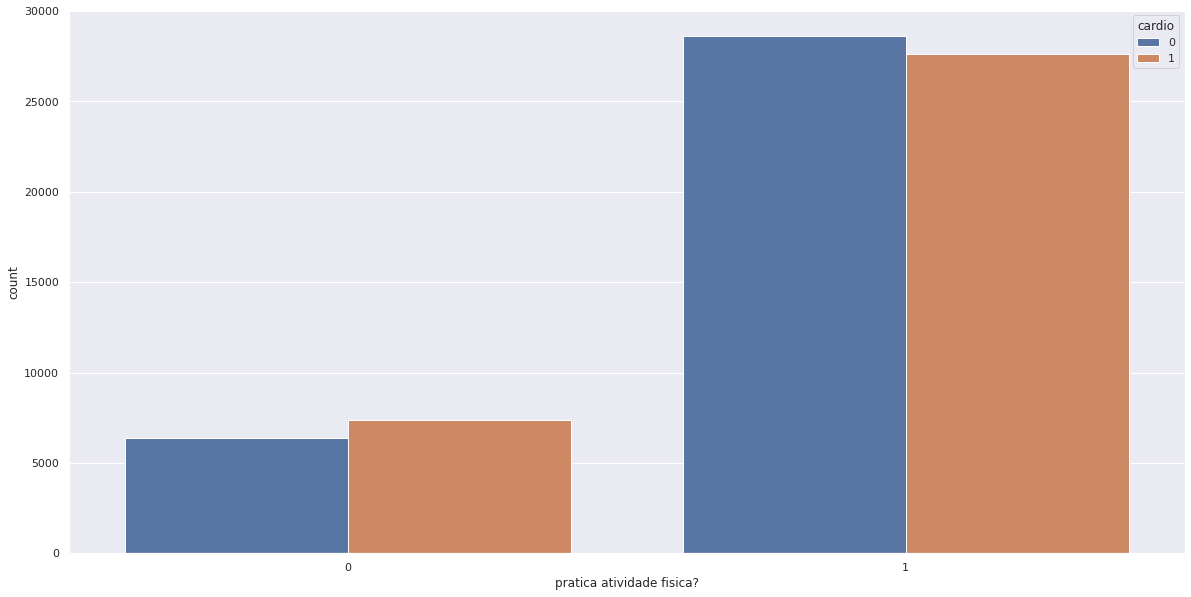

In [27]:
#plot graph
sns.countplot(x='active', hue= 'cardio',data = df3);

plt.xlabel("pratica atividade fisica?");


### H6- Pessoas que tem o colesterol muito acima do normal deveriam ser mais propensas a ter cardio disease
**VERDADE**

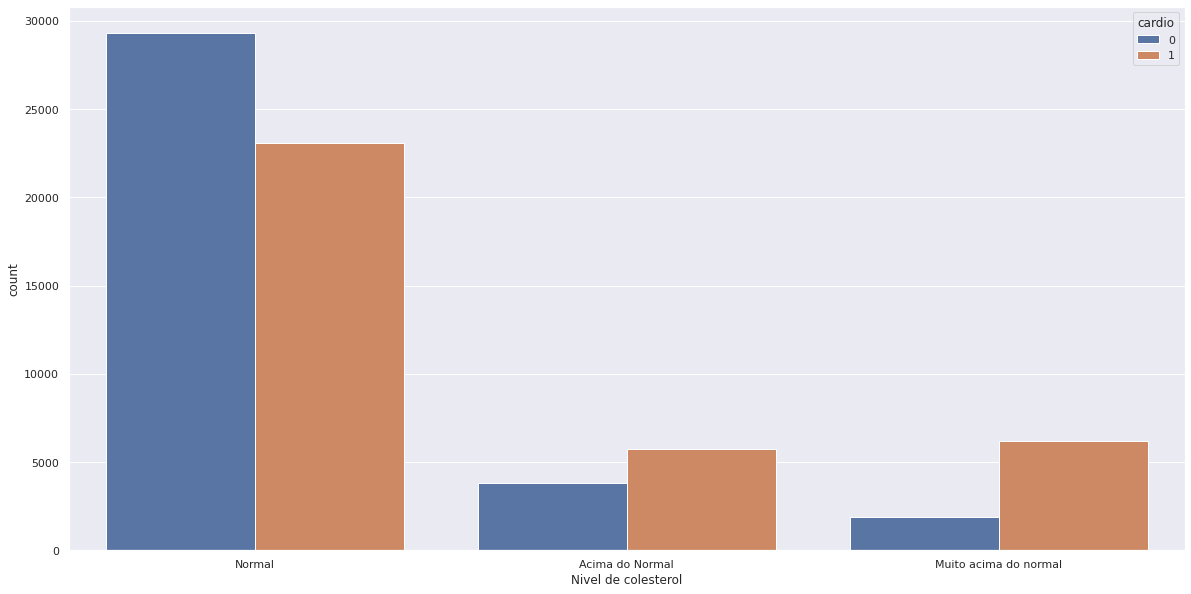

In [28]:
#plot graph
sns.countplot(x = 'cholesterol', hue= 'cardio', data = df3);

plt.xticks(ticks=[0,1,2],labels=['Normal','Acima do Normal','Muito acima do normal']);
plt.xlabel("Nivel de colesterol");


### H7- Pessoas que tem o blood pressure 3 e 4 deveriam ser mais propensas a ter cardio disease
**Apenas pessoas com blood pressure 4 tem mais propensão**

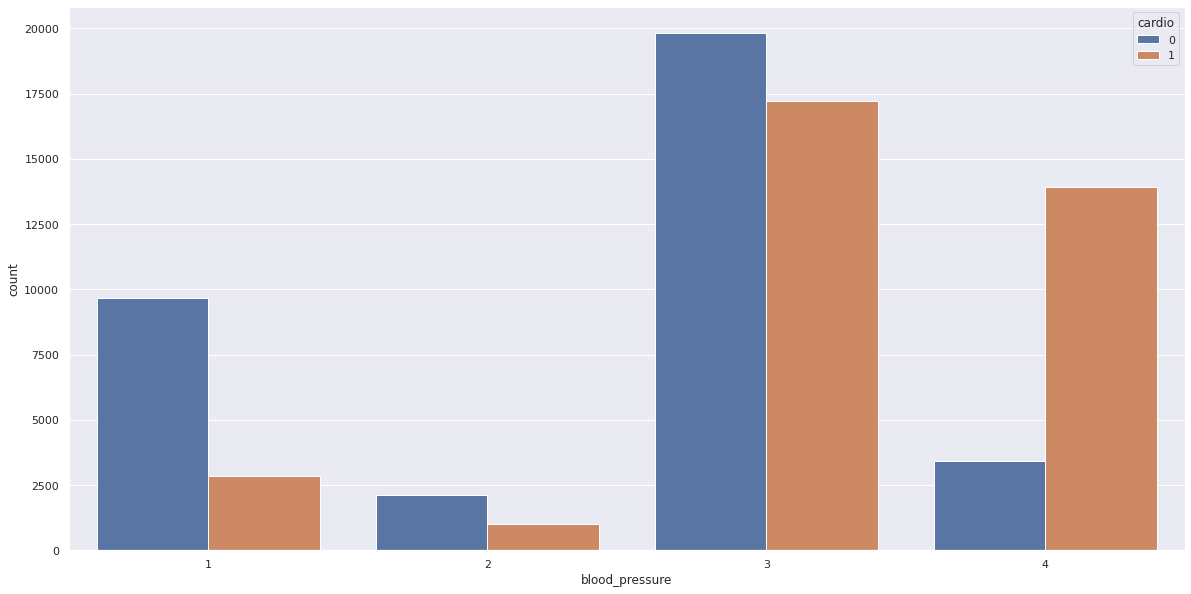

In [29]:
#plot graph
sns.countplot(x='blood_pressure', hue = 'cardio' ,data = df3);



### H8- Pessoas que tem nivel de glicose mais alto deveriam ser mais propensas a ter cardio disease
**VERDADE**

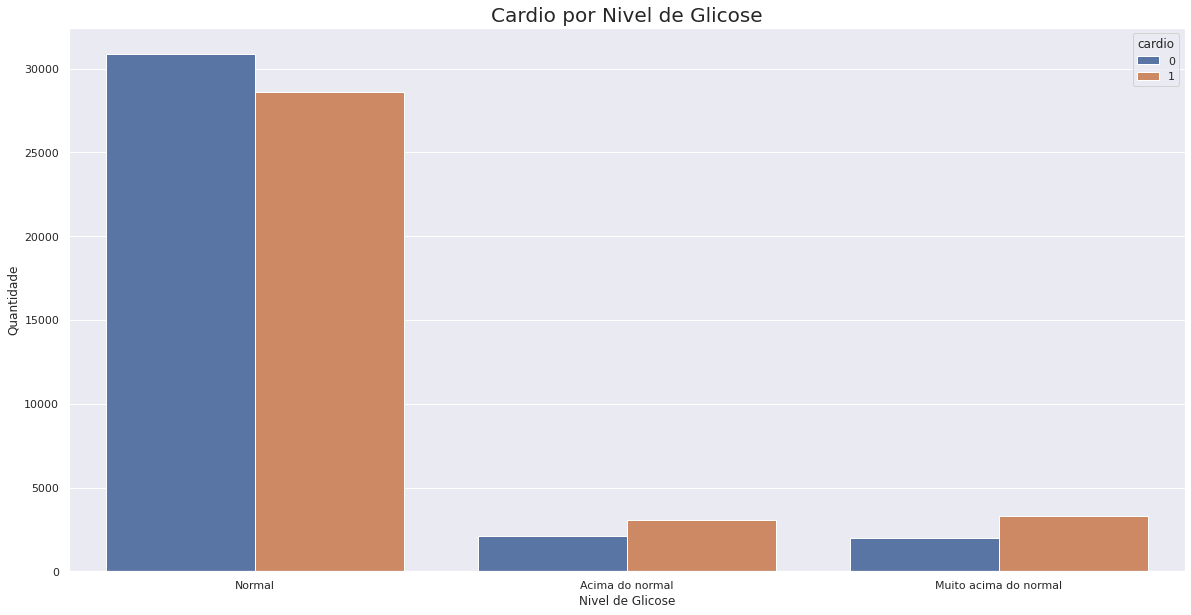

In [30]:

#plot graph
sns.countplot(x = 'gluc' , hue = 'cardio',data = df3);

plt.title("Cardio por Nivel de Glicose",fontsize=20);
plt.xlabel("Nivel de Glicose");
plt.ylabel("Quantidade")
plt.xticks(ticks=[0,1,2],labels=['Normal','Acima do normal','Muito acima do normal']);


### H9 Homens deveriam ter mais chance de adquirir cardio disease do que as mulheres.
**FALSO**



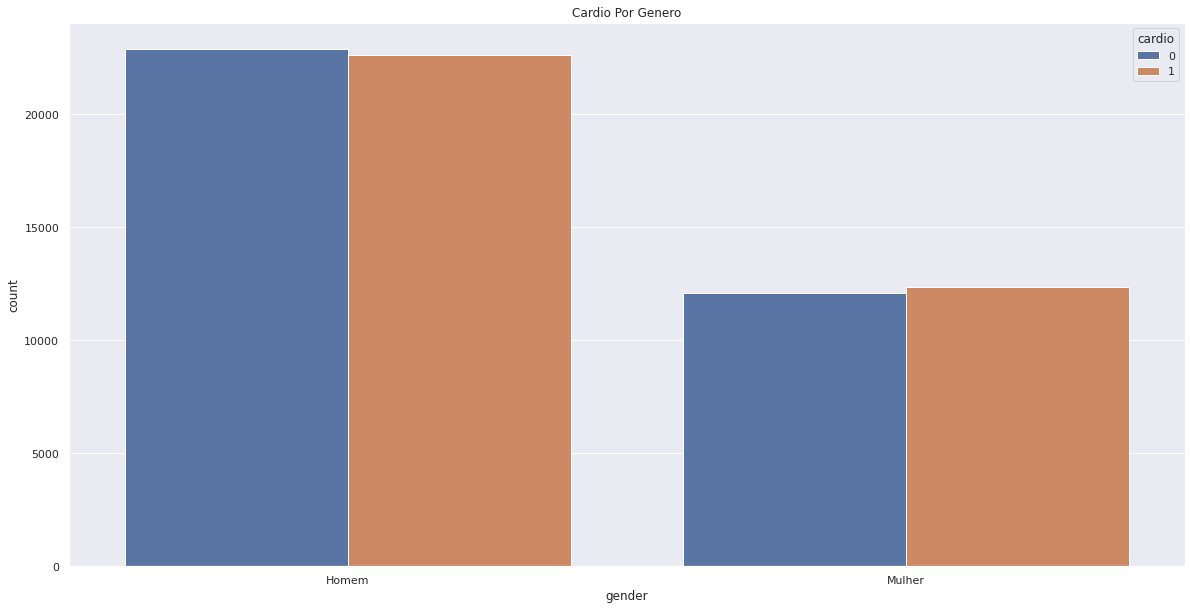

In [31]:

sns.countplot(x = 'gender', hue = 'cardio', data = df3);
plt.title("Cardio Por Genero");
plt.xticks(ticks=[0,1],labels=['Homem','Mulher']);


### H10 homens que fumam deveriam ter mais chances do que mulheres que fumam 
**True**

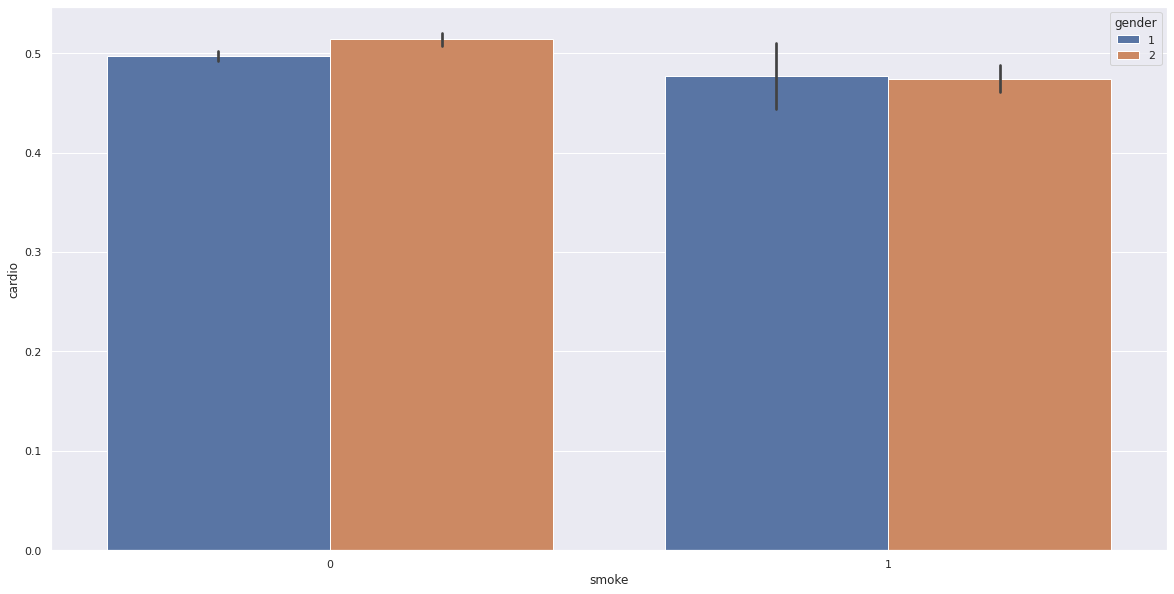

In [32]:

sns.barplot(x = 'smoke', y = 'cardio', hue = 'gender', data = df3);



## 3.3 Analise Multivariada 

### 3.3.1 Variaveis numericas 

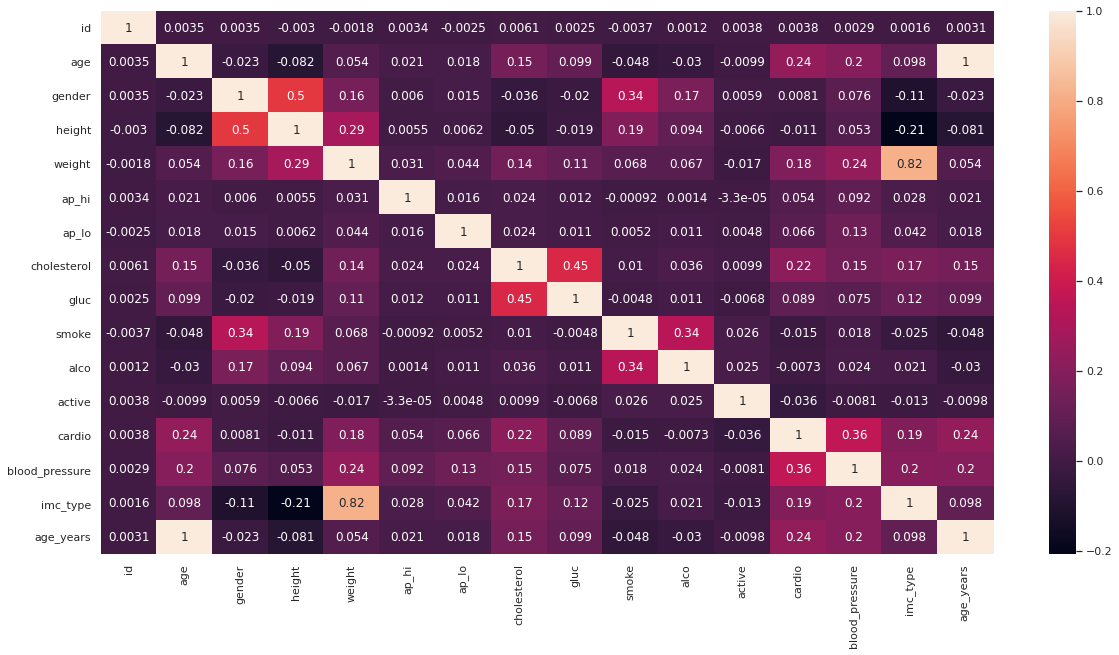

In [33]:
#Image('img/Pearson.png')
num = df3.select_dtypes(include = ['float64', 'int64'])
corre = num.corr(method = 'pearson')
sns.heatmap(corre,annot=True);

### 3.3.2 Variaveis Categoricas


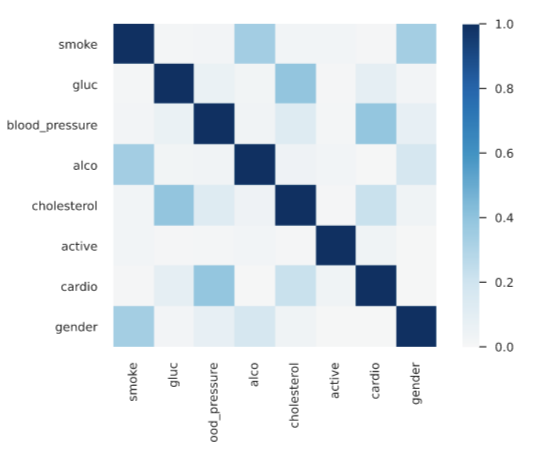

In [34]:
Image('img/Cramer.png')

# 4.0 Data Preparation 

In [35]:
df4 = df3.copy()

# 5.0 Feature Selection

In [36]:
df5 = df4.copy()

## 5.1 split train and test dataset 

In [37]:
#training data set
x_train, x_test, y_train, y_test = train_test_split(df5,df5['cardio'], random_state = 42, test_size= 0.25)

In [38]:
#delete columns
x_train = x_train.drop( [ 'id','cardio','age_years'], axis=1 )
x_test = x_test.drop( ['id','cardio','age_years'], axis=1  )



In [39]:
#training dataset for cross validation
x_train_cv = x_train
y_train_cv = y_train

## 5.2 Boruta as Feature Selector

# 6.0 Machine Learning Models

In [40]:
df6 = df5.copy()

## 6.1 Dummy Classifier - Baseline 

In [41]:
#MODEL
dum = DummyClassifier().fit(x_train, y_train)

#predictions
yhat_dummy = dum.predict( x_test)

#perfomance
dum_result = classification_report(y_test, yhat_dummy)

print(dum_result)

              precision    recall  f1-score   support

           0       0.49      0.49      0.49      8688
           1       0.50      0.49      0.49      8812

    accuracy                           0.49     17500
   macro avg       0.49      0.49      0.49     17500
weighted avg       0.49      0.49      0.49     17500



/home/pc/anaconda/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


## 6.2 Nearest Centroid Classifier

In [42]:

#MODEL
nc1 = NearestCentroid().fit(x_train, y_train)

#predictions
yhat_nc1 = nc1.predict( x_test)

#perfomance
nc_result = classification_report(y_test, yhat_nc1 )

print(nc_result)

              precision    recall  f1-score   support

           0       0.61      0.54      0.57      8688
           1       0.59      0.65      0.62      8812

    accuracy                           0.60     17500
   macro avg       0.60      0.60      0.60     17500
weighted avg       0.60      0.60      0.60     17500



## 6.3 Decision Tree Classifier 




In [43]:
#MODEL
dtc = tree.DecisionTreeClassifier().fit(x_train, y_train)

#predictions
yhat_dtc = dtc.predict( x_test)

#perfomance
dtc_result = classification_report(y_test, yhat_dtc )
print(dtc_result)

              precision    recall  f1-score   support

           0       0.63      0.63      0.63      8688
           1       0.63      0.63      0.63      8812

    accuracy                           0.63     17500
   macro avg       0.63      0.63      0.63     17500
weighted avg       0.63      0.63      0.63     17500



## 6.4 Naive Bayes


In [44]:
#MODEL
gnb = GaussianNB().fit(x_train, y_train)

#predictions
yhat_gnb = gnb.predict( x_test)

#perfomance
gnb_result = classification_report(y_test, yhat_gnb )
print(gnb_result)

              precision    recall  f1-score   support

           0       0.59      0.84      0.70      8688
           1       0.73      0.44      0.55      8812

    accuracy                           0.64     17500
   macro avg       0.66      0.64      0.62     17500
weighted avg       0.66      0.64      0.62     17500



## 6.5 Logistic Regression

In [45]:
#MODEL
lr = LogisticRegression().fit(x_train, y_train)

#predictions
yhat_lr = lr.predict( x_test)

#perfomance
lr_result = classification_report(y_test, yhat_lr )
print(lr_result)

              precision    recall  f1-score   support

           0       0.69      0.76      0.72      8688
           1       0.74      0.66      0.70      8812

    accuracy                           0.71     17500
   macro avg       0.71      0.71      0.71     17500
weighted avg       0.71      0.71      0.71     17500



/home/pc/anaconda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## 6.6 LDA classifier

In [46]:
#MODEL
lda = LinearDiscriminantAnalysis().fit(x_train, y_train)

#predictions
yhat_lda = lda.predict( x_test)

#perfomance
lda_result = classification_report(y_test, yhat_lda )
print(lda_result)

              precision    recall  f1-score   support

           0       0.70      0.67      0.68      8688
           1       0.69      0.72      0.70      8812

    accuracy                           0.69     17500
   macro avg       0.69      0.69      0.69     17500
weighted avg       0.69      0.69      0.69     17500



##  6.7 XGBClassifier 

In [47]:
#MODEL
xgb = xgb.XGBClassifier(objective='binary:logistic').fit(x_train, y_train)

#predictions
yhat_xgb = xgb.predict( x_test)

#perfomance
xgb_result = classification_report(y_test, yhat_xgb )
print(xgb_result)

/home/pc/anaconda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:48:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.71      0.78      0.74      8688
           1       0.76      0.69      0.72      8812

    accuracy                           0.73     17500
   macro avg       0.74      0.73      0.73     17500
weighted avg       0.74      0.73      0.73     17500



## 6.8 SGDClassifier 

In [48]:
#MODEL
sgd = SGDClassifier(max_iter=1000, tol=1e-3).fit(x_train, y_train)

#predictions
yhat_sgd = sgd.predict( x_test)

#perfomance
sgd_result = classification_report(y_test, yhat_sgd )
print(sgd_result)

              precision    recall  f1-score   support

           0       0.85      0.19      0.31      8688
           1       0.55      0.97      0.70      8812

    accuracy                           0.58     17500
   macro avg       0.70      0.58      0.51     17500
weighted avg       0.70      0.58      0.51     17500



## 6.9 LGBMClassifier 

In [49]:
#MODEL
lgbm = LGBMClassifier().fit(x_train, y_train)

#predictions
yhat_lgbm = lgbm.predict( x_test)

#perfomance
lgbm_result = classification_report(y_test, yhat_lgbm )
print(lgbm_result)

              precision    recall  f1-score   support

           0       0.72      0.78      0.75      8688
           1       0.76      0.70      0.73      8812

    accuracy                           0.74     17500
   macro avg       0.74      0.74      0.74     17500
weighted avg       0.74      0.74      0.74     17500



# 7.0 Cross validation

In [50]:
#kfold strategy
cv1 = StratifiedKFold( n_splits = 10)

## 7.1 Nearest Centroid Classifier - Cross validation

In [51]:
nc = NearestCentroid()
cv_scores = cross_val_score( nc, x_train_cv, np.ravel( y_train_cv), cv =cv1, scoring ='precision', n_jobs=-1 )
print(" média precisão %0.4f (+/- %0.4f)" %(cv_scores.mean(), cv_scores.std()*2 ) )

cv_scores = cross_val_score( nc, x_train_cv,  y_train_cv, cv =cv1, scoring ='recall', n_jobs=-1 )
print("\n média recall %0.4f (+/- %0.4f)" %(cv_scores.mean(), cv_scores.std()*2 ) )

cv_scores = cross_val_score( nc, x_train_cv, np.ravel( y_train_cv), cv =cv1, scoring ='f1', n_jobs=-1 )
print("\n média f1 %0.4f (+/- %0.4f)" %(cv_scores.mean(), cv_scores.std()*2 )  )
      

 média precisão 0.5867 (+/- 0.0148)

 média recall 0.6449 (+/- 0.0262)

 média f1 0.6144 (+/- 0.0182)


## 7.2 Decision Tree Classifier - Cross Validation




In [52]:
dtc = tree.DecisionTreeClassifier()
cv_scores = cross_val_score( dtc, x_train_cv, np.ravel( y_train_cv), cv =cv1, scoring ='precision', n_jobs=-1 )
print(" média precisão %0.4f (+/- %0.4f)" %(cv_scores.mean(), cv_scores.std()*2 ) )

cv_scores = cross_val_score( dtc, x_train_cv,  y_train_cv, cv =cv1, scoring ='recall', n_jobs=-1 )
print("\n média recall %0.4f (+/- %0.4f)" %(cv_scores.mean(), cv_scores.std()*2 ) )

cv_scores = cross_val_score( dtc, x_train_cv, np.ravel( y_train_cv), cv =cv1, scoring ='f1', n_jobs=-1 )
print("\n média f1 %0.4f (+/- %0.4f)" %(cv_scores.mean(), cv_scores.std()*2 )  )
      

 média precisão 0.6296 (+/- 0.0107)

 média recall 0.6303 (+/- 0.0199)

 média f1 0.6307 (+/- 0.0150)


## 7.3 Naive Bayes - Cross Validation


In [53]:
gnb = GaussianNB()
cv_scores = cross_val_score( gnb, x_train_cv, np.ravel( y_train_cv), cv =cv1, scoring ='precision', n_jobs=-1 )
print(" média precisão %0.4f (+/- %0.4f)" %(cv_scores.mean(), cv_scores.std()*2 ) )

cv_scores = cross_val_score( gnb, x_train_cv,  y_train_cv, cv =cv1, scoring ='recall', n_jobs=-1 )
print("\n média recall %0.4f (+/- %0.4f)" %(cv_scores.mean(), cv_scores.std()*2 ) )

cv_scores = cross_val_score( gnb, x_train_cv, np.ravel( y_train_cv), cv =cv1, scoring ='f1', n_jobs=-1 )
print("\n média f1 %0.4f (+/- %0.4f)" %(cv_scores.mean(), cv_scores.std()*2 )  )
      

 média precisão 0.7276 (+/- 0.0137)

 média recall 0.4271 (+/- 0.0635)

 média f1 0.5375 (+/- 0.0523)


## 7.4 Logistic Regression - Cross Validation

In [54]:
lr = LogisticRegression()
cv_scores = cross_val_score( lr, x_train_cv, np.ravel( y_train_cv), cv =cv1, scoring ='precision', n_jobs=-1 )
print(" média precisão %0.4f (+/- %0.4f)" %(cv_scores.mean(), cv_scores.std()*2 ) )

cv_scores = cross_val_score( lr, x_train_cv,  y_train_cv, cv =cv1, scoring ='recall', n_jobs=-1 )
print("\n média recall %0.4f (+/- %0.4f)" %(cv_scores.mean(), cv_scores.std()*2 ) )

cv_scores = cross_val_score( lr, x_train_cv, np.ravel( y_train_cv), cv =cv1, scoring ='f1', n_jobs=-1 )
print("\n média f1 %0.4f (+/- %0.4f)" %(cv_scores.mean(), cv_scores.std()*2 )  )

 média precisão 0.7025 (+/- 0.0163)

 média recall 0.6757 (+/- 0.0634)

 média f1 0.6884 (+/- 0.0292)


## 7.5 LDA classifier - Cross Validation

In [55]:
lda = LinearDiscriminantAnalysis()
cv_scores = cross_val_score( lda, x_train_cv, np.ravel( y_train_cv), cv =cv1, scoring ='precision', n_jobs=-1 )
print(" média precisão %0.4f (+/- %0.4f)" %(cv_scores.mean(), cv_scores.std()*2 ) )

cv_scores = cross_val_score( lda, x_train_cv,  y_train_cv, cv =cv1, scoring ='recall', n_jobs=-1 )
print("\n média recall %0.4f (+/- %0.4f)" %(cv_scores.mean(), cv_scores.std()*2 ) )

cv_scores = cross_val_score( lda, x_train_cv, np.ravel( y_train_cv), cv =cv1, scoring ='f1', n_jobs=-1 )
print("\n média f1 %0.4f (+/- %0.4f)" %(cv_scores.mean(), cv_scores.std()*2 )  )

 média precisão 0.6874 (+/- 0.0128)

 média recall 0.7253 (+/- 0.0221)

 média f1 0.7058 (+/- 0.0131)


##  7.6 XGBClassifier - Cross Validation


In [56]:

cv_scores = cross_val_score( xgb, x_train_cv, np.ravel( y_train_cv), cv =cv1, scoring ='precision', n_jobs=-1 )
print(" média precisão %0.4f (+/- %0.4f)" %(cv_scores.mean(), cv_scores.std()*2 ) )

cv_scores = cross_val_score( xgb, x_train_cv,  y_train_cv, cv =cv1, scoring ='recall', n_jobs=-1 )
print("\n média recall %0.4f (+/- %0.4f)" %(cv_scores.mean(), cv_scores.std()*2 ) )

cv_scores = cross_val_score( xgb, x_train_cv, np.ravel( y_train_cv), cv =cv1, scoring ='f1', n_jobs=-1 )
print("\n média f1 %0.4f (+/- %0.4f)" %(cv_scores.mean(), cv_scores.std()*2 )  )

 média precisão 0.7522 (+/- 0.0094)

 média recall 0.6908 (+/- 0.0173)

 média f1 0.7202 (+/- 0.0109)


## 7.7 SGDClassifier - Cross Validation


In [57]:
sgd = SGDClassifier(max_iter=1000, tol=1e-3)
cv_scores = cross_val_score( sgd, x_train_cv, np.ravel( y_train_cv), cv =cv1, scoring ='precision', n_jobs=-1 )
print(" média precisão %0.4f (+/- %0.4f)" %(cv_scores.mean(), cv_scores.std()*2 ) )

cv_scores = cross_val_score( sgd, x_train_cv,  y_train_cv, cv =cv1, scoring ='recall', n_jobs=-1 )
print("\n média recall %0.4f (+/- %0.4f)" %(cv_scores.mean(), cv_scores.std()*2 ) )

cv_scores = cross_val_score( sgd, x_train_cv, np.ravel( y_train_cv), cv =cv1, scoring ='f1', n_jobs=-1 )
print("\n média f1 %0.4f (+/- %0.4f)" %(cv_scores.mean(), cv_scores.std()*2 )  )

 média precisão 0.7224 (+/- 0.3195)

 média recall 0.4994 (+/- 0.7041)

 média f1 0.4200 (+/- 0.5841)


## 7.8 LGBMClassifier - Cross Validation

In [58]:
lgbm_clf = LGBMClassifier()
cv_scores = cross_val_score( lgbm_clf, x_train_cv, np.ravel( y_train_cv), cv =cv1, scoring ='precision', n_jobs=-1 )
print("média precisão %0.4f (+/- %0.4f)" %(cv_scores.mean(), cv_scores.std()*2 ) )

cv_scores = cross_val_score( lgbm_clf, x_train_cv,  y_train_cv, cv =cv1, scoring ='recall', n_jobs=-1 )
print("\n média recall %0.4f (+/- %0.4f)" %(cv_scores.mean(), cv_scores.std()*2 ) )

cv_scores = cross_val_score( lgbm_clf, x_train_cv, np.ravel( y_train_cv), cv =cv1, scoring ='f1', n_jobs=-1 )
print("\n média f1 %0.4f (+/- %0.4f)" %(cv_scores.mean(), cv_scores.std()*2 )  )
      


média precisão 0.7562 (+/- 0.0147)

 média recall 0.6934 (+/- 0.0167)

 média f1 0.7234 (+/- 0.0114)


# 8.0 Hyperparemeter fine tuning

## 8.1 Random search


In [59]:
# instantiate the classifier

lgbm_clf = LGBMClassifier(random_state=33, n_jobs=-1)

In [60]:
 # set up space dictionary with specified hyperparameters
param = {'max_depth': np.arange(2, 12, 2), 
         'num_leaves': 2 ** np.arange(2, 10, 2),
         'min_data_in_leaf': np.arange(100, 1050, 50), 
         'learning_rate': np.linspace(0.001, 0.6, 15),
         'colsample_bytree': np.linspace(0.1, 1, 5),
         'subsample': np.linspace(0.25, 1, 15),
         'n_estimators': np.arange(10, 105, 15)}

In [61]:
# prepare RandomizedSearchCV 
lgbm_clf_cv = RandomizedSearchCV(estimator=lgbm_clf, param_distributions=param,
                                scoring='recall', n_iter=100, cv=5, verbose=2,
                                random_state=33, n_jobs=-1)

In [62]:
# fits 
lgbm_clf_cv.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 150 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 353 tasks      | elapsed:  1.4min


[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.0min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=33, reg_alpha=0.0,
                                            reg_lambda=0.0, silent...
                                        'n_estimators': array([ 10,  25,  40,  55,  70,  85, 100]),
                         

In [63]:
#best parameters
lgbm_clf_cv.best_estimator_


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.775,
               importance_type='split', learning_rate=0.5144285714285713,
               max_depth=4, min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=900, min_split_gain=0.0, n_estimators=40,
               n_jobs=-1, num_leaves=4, objective=None, random_state=33,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.625,
               subsample_for_bin=200000, subsample_freq=0)

## 8.2 Final Model


In [67]:
#MODEL
lgbm = lgbm_clf_cv.best_estimator_
#save trained model
pickle.dump( lgbm, open ( '/home/pc/Documents/PA/01/model_cardio.pkl', 'wb' ) )



## 8.3 Metrics Final Model

In [68]:
#Perfomance cross validation

cv_scores = cross_val_score( lgbm, x_train_cv, np.ravel( y_train_cv), cv =cv1, scoring ='precision', n_jobs=-1 )
print("Average Precision %0.4f (+/- %0.4f)" %(cv_scores.mean(), cv_scores.std()*2 ) )

cv_scores = cross_val_score( lgbm, x_train_cv,  y_train_cv, cv =cv1, scoring ='recall', n_jobs=-1 )
print("\n Average Recall %0.4f (+/- %0.4f)" %(cv_scores.mean(), cv_scores.std()*2 ) )

cv_scores = cross_val_score( lgbm, x_train_cv, np.ravel( y_train_cv), cv =cv1, scoring ='f1', n_jobs=-1 )
print("\n Average f1-score %0.4f (+/- %0.4f)" %(cv_scores.mean(), cv_scores.std()*2 )  )

Average Precision 0.7505 (+/- 0.0148)

 Average Recall 0.6986 (+/- 0.0183)

 Average f1-score 0.7236 (+/- 0.0126)


## 8.4 Cross validation summary

|     Model                                  | Avg Precision             | Avg Recall                | Avg f1\-score             
|--------------------------------------------|---------------------------|---------------------------|---------------------------
| LGBM Classifier                            | 0\.7562 \(\+/\- 0\.0147\) | 0\.0934 \(\+/\- 0\.0167\) | 0\.7234 \(\+/\- 0\.0114\) 
| LGBM Classifier \(Tuned HP\)               | 0.7505 (+/- 0\.0148\)     | 0\.6989 \(\+/\- 0\.0183\) | 0\.7236 \(\+/\- 0\.0126\) 


## 8.5 Calculate Business perfomance

In [69]:
#model performance business
price_per_percent = 500/5

baseline = 50
num_pacients = 70000

model_accuracy = cv_scores.mean()
deviation = cv_scores.std() * 2


accuracy_lower = (model_accuracy - deviation) * 100
accuracy_upper = (model_accuracy + deviation) * 100

percent_difference_lower = accuracy_lower - baseline
percent_difference_upper = accuracy_upper - baseline

amount_best = percent_difference_upper * price_per_percent * num_pacients
amount_worst = percent_difference_lower * price_per_percent * num_pacients

print(f'Best:  ${round(amount_best, 2):,.2f}')
print(f'Worst: ${round(amount_worst, 2):,.2f}')

Best:  $165,305,455.95
Worst: $147,682,954.67


In [70]:
#today's performance

price_per_percent = 500/5

baseline = 50
num_pacients = 70000



accuracy_lower = 55.0
accuracy_upper = 65.0

percent_difference_lower = accuracy_lower - baseline
percent_difference_upper = accuracy_upper - baseline

amount_best = percent_difference_upper * price_per_percent * num_pacients
amount_worst = percent_difference_lower * price_per_percent * num_pacients

print(f'Best:  ${round(amount_best, 2):,.2f}')
print(f'Worst: ${round(amount_worst, 2):,.2f}')

Best:  $105,000,000.00
Worst: $35,000,000.00


In [73]:
import pickle
import pandas as pd


class Cardio( object ):
    
    def __init__(self):
        self.home_path = '/home/pc/Documents/PA/01'
        self.model = pickle.load( open( self.home_path + 'model_Cardio.pkl', 'rb' ) )
        
        
    def data_preparation(self , df2 ):
        #creating new features
        #blood_pressure
        df2['blood_pressure'] = df2.apply( (lambda x: 1 if (x['ap_hi'] < 120) & (x['ap_lo'] <= 80) else 2 if (120 <= x['ap_hi'] <= 129) & (x['ap_lo'] < 80) else 3 if (130 <= x['ap_hi'] < 139) or ( 80 <= x['ap_lo'] <= 89) else 4 ),axis =1 ) 

        #IMC = WEIGHT/HEIGHT^2
        df2['height2'] = df2['height']/100

        df2['imc'] = (df2['weight']/(df2['height2']**2))

        #imc_type
        df2['imc_type'] = df2.apply( (lambda x : 1 if x['imc'] < 18.5 else 2 if  18.5 <= x['imc'] < 25.0 else 3 if 25 <= x['imc'] < 30.0 else 4 if  30.0 <= x['imc'] < 35.0 else 5 if 35 <= x['imc'] < 40.0 else 6) ,axis=1)

        #create columns age by year
        df2['age'] = df2['age'].apply(lambda x: x*365)
        
        #delete aux columns
        cols_drop = ['height2','imc']
        df2 = df2.drop(cols_drop,axis=1)
        
        return df2
    
    def get_predict(self, df3 ):
        
        #predidction
        pred = self.model.predict( df3 )
        
        #translating the response
        
        if pred == 1:
            res = "you have a huge chance of having heart disease"
        else:
            res = "you have a very low chance of having heart disease"
            
        return res
    
                


    
    

# 9.0 Business performance

<font size = '4'>


The price of the diagnosis, paid by the client, varies according to the precision achieved by the team of specialists.

| Exam Accuracy | Price          | Rules                                    | Example                         |
|:--------------|:---------------|:-----------------------------------------|:--------------------------------|
| Above 50%     | min \$500\.00  | \+\$500 for each additional 5% precision | Precision = 55% \-> \$1,000\.00 |
| Up to 50%     | $0\.00         | N/A                                      | N/A                             |





Translating my model's performance it to business numbers.

| Exam Accuracy | Best Scenario    | Worst Scenario         |
|:--------------|:-----------------|:---------------------- |
| Our Model     | \$165,305,455.95 | \$147,682,954\.67      |
| Today         | \$105,000,000.00 | \$35,000,000\.00       |  